# 🚀 Beyond Guesswork: Automated ML Model Selection 
## Highlights:
- ✅ Loads dataset
- ✅ Data cleaning, feature engineering, and encoding
- ✅ Compares 5 different algorithms with proper scaling
- ✅ Uses GridSearchCV for hyperparameter tuning with cross-validation
- ✅ Evaluates on held-out test data to prevent overfitting
- ✅ Ranks models by performance and provides detailed analysis

### Load Dataset
- 🚢 **Titanic**

In [4]:
from sklearn.datasets import fetch_openml
titanic = fetch_openml("titanic", version=1, as_frame=True)
df = titanic.frame
df.head(2)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


### Data exploration and visualization
- Importing basic libraries for  understanding the dataset and visualization

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (6,4)

In [6]:
df.shape

(1309, 14)

In [7]:
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [8]:
df[['pclass','age', 'sibsp', 'parch','fare','survived']].groupby("survived",observed=False).agg(["mean","median"])

pclass               age            sibsp            parch         \
              mean median       mean median      mean median      mean median   
survived                                                                        
0         2.500618    3.0  30.545369   28.0  0.521632    0.0  0.328801    0.0   
1         1.962000    2.0  28.918228   28.0  0.462000    0.0  0.476000    0.0   

               fare         
               mean median  
survived                    
0         23.353831   10.5  
1         49.361184   26.0

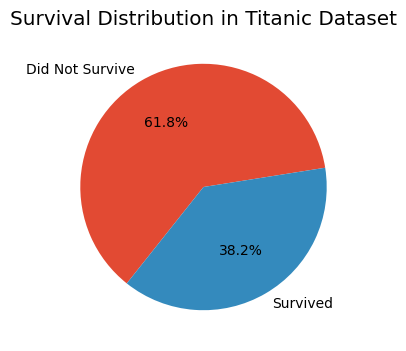

In [9]:
survival_counts = df['survived'].value_counts()
plt.pie(survival_counts, labels=['Did Not Survive', 'Survived'], 
        autopct='%1.1f%%', startangle=9)
plt.title('Survival Distribution in Titanic Dataset')
plt.show()

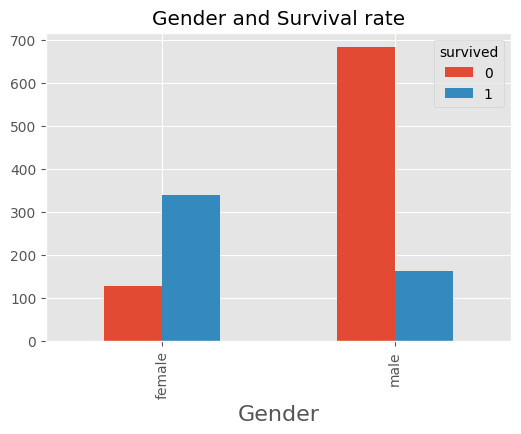

In [24]:
pd.crosstab(df.sex,df.survived).plot(kind="bar")
plt.title("Gender and Survival rate")
plt.xlabel("Gender",fontsize=16)
plt.show()

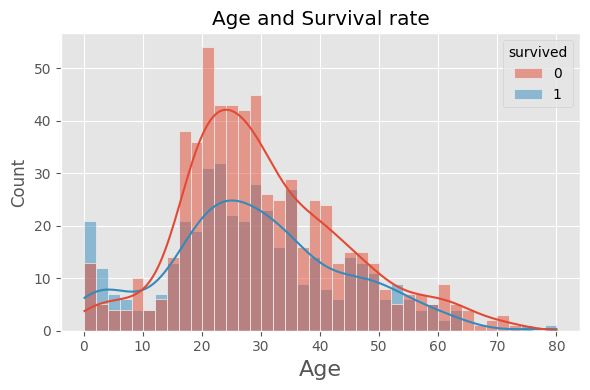

In [25]:
sns.histplot(data=df,bins=40,x="age",kde=True,hue="survived")
plt.title("Age and Survival rate")
plt.xlabel("Age",fontsize=16)
plt.tight_layout()
plt.show()

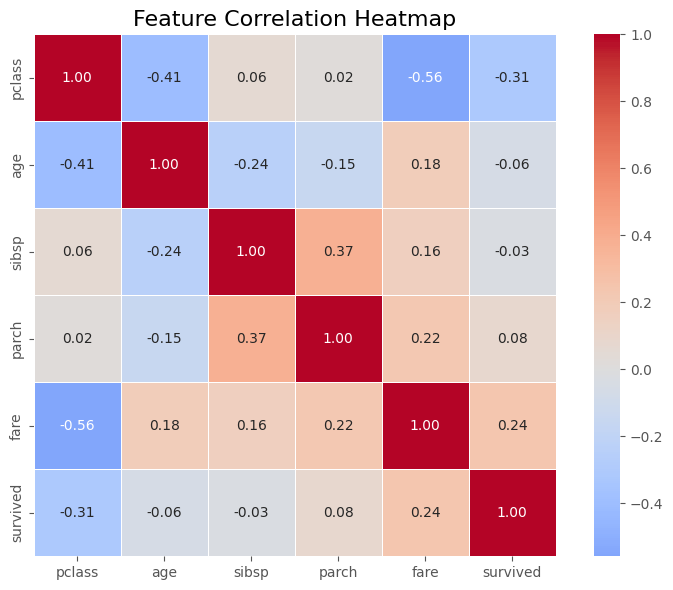

In [22]:
plt.figure(figsize=(8, 6))
correlation_matrix = df[['pclass','age', 'sibsp', 'parch','fare','survived']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

## Observation
- **From the data analysis so far we can conclude that we will use following variables as independant variables in our model**
- **pclass**, **sex**, **age**, **sibsp**, **parch** and **fare** are the primary variables impacting survival rate




In [143]:
final_df = df[['pclass','sex','age','sibsp','parch','fare','embarked','survived']]
final_df.head(3)

,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,1,female,29.0000,0,0,211.3375,S,1
1,1,male,0.9167,1,2,151.5500,S,1
2,1,female,2.0000,1,2,151.5500,S,0


## Data cleaning and preprocessing


In [151]:
from sklearn.preprocessing import LabelEncoder 
import warnings as wr
le = LabelEncoder()
wr.filterwarnings("ignore")

In [146]:
final_df.age = final_df.age.fillna(final_df.age.mean())

In [173]:
final_df = final_df.dropna()

In [174]:
final_df.isna().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
survived    0
dtype: int64

In [176]:
final_df.sex = le.fit_transform(final_df.sex)
final_df.embarked = le.fit_transform(final_df.embarked)

In [177]:
final_df.head(3)

,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,1,0,29.0000,0,0,211.3375,2,1
1,1,1,0.9167,1,2,151.5500,2,1
2,1,0,2.0000,1,2,151.5500,2,0


### Finla dataset for train and test use

In [178]:
inputs = final_df.drop(["survived"],axis=1)
target = final_df.survived.astype(int)

## Model selection
- **Using hypeparameter and cross validation to find the best model and the parameters**

In [199]:
## Imporing Models

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [200]:
## train test split
X_train, X_test, y_train, y_test = train_test_split(inputs,target,test_size=0.3,random_state=42)

## Feature scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Creating a dictionary of models 

In [201]:
## Model configuration with scaling 

model_dict = {
    "svm": {
        "model": svm.SVC(random_state=42),
        "para": {
            "C": [1, 5, 10, 20],
            "kernel": ["rbf", "linear"],
            "gamma": ['scale', 'auto']
        },
        "use_scaled": True  # SVM benefits from scaling
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "para": {
            "n_estimators": [30, 50, 80],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "criterion": ["gini", "entropy"]
        },
        "use_scaled": False  # Trees don't need scaling
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "para": {
            "C": [0.1, 1, 5, 10],
            "solver": ['lbfgs', 'liblinear']
        },
        "use_scaled": True  # Logistic Regression needs scaling
    },
    "Naive Gaussian": {
        "model": GaussianNB(),
        "para": {},
        "use_scaled": False  # Gaussian NB handles original scale
    },
    "Naive Multinomial": {
        "model": MultinomialNB(),
        "para": {},
        "use_scaled": True  # Multinomial NB NEEDS non-negative features
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "para": {
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "criterion": ["gini", "entropy"],
            "max_depth": [3, 5, 7, None]
        },
        "use_scaled": False  # Trees don't need scaling
    }
}

## Selecting the best model and the parameters

In [208]:
results = []
training_times = []

print("Starting model comparison with Titanic dataset...\n")

for name, model in model_dict.items():
    print(f"🚀 Training {name}...")
    start_time = time.time()
    
    ## Choose the right data (scaled or original)
    if model["use_scaled"]:
        X_train_used = X_train_scaled
    else:
        X_train_used = X_train
        
    ## Hyperparameter tuning with cross-validation
    grid_search = GridSearchCV(
        estimator=model["model"],
        param_grid=model["para"],
        cv=5, 
        scoring='accuracy',
        return_train_score=False,
        n_jobs=-1
    )
    
    grid_search.fit(X_train_used, y_train)
    training_time = time.time() - start_time

    results.append({
        "model_name": name,
        "best_score": f"{grid_search.best_score_:.3f}",
        "training_time (s)": f"{training_time:.2f}",
        "best_parameters": str(grid_search.best_params_)
    })
    
print("\n📊 FINAL RESULTS:")

result_df = pd.DataFrame(results)
result_df = result_df.sort_values("best_score", ascending=False,ignore_index=True)
result_df

Starting model comparison with Titanic dataset...

🚀 Training svm...
🚀 Training Random Forest...
🚀 Training Logistic Regression...
🚀 Training Naive Gaussian...
🚀 Training Naive Multinomial...
🚀 Training Decision Tree...

📊 FINAL RESULTS:


,model_name,best_score,training_time (s),best_parameters
0,Random Forest,0.812,24.70,"{'criterion': 'entropy', 'min_samples_leaf': 2..."
1,Decision Tree,0.812,2.13,"{'criterion': 'gini', 'max_depth': 3, 'min_sam..."
2,svm,0.809,1.01,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}"
3,Naive Gaussian,0.797,0.05,{}
4,Logistic Regression,0.793,0.26,"{'C': 5, 'solver': 'lbfgs'}"
5,Naive Multinomial,0.659,0.05,{}


### Above result showing
- 🏆 **Random Forest** emerged as the best model with **82%** accuracy
- ⚡ **Naive Models** were the **fastest** to train
  
   ---------------------------------------------------

## Final model testing and result

In [219]:
## final model
best_model = result_df.loc[0]["model_name"]
model_config = model_dict[best_model] 

## scaling the data
X_train_final = X_train_scaled if model_config["use_scaled"] else X_train
X_test_final = X_test_scaled if model_config["use_scaled"] else X_test

## final selection
final_grid_search = GridSearchCV(
        estimator=model_config["model"],
        param_grid=model_config["para"],
        cv=5, 
        scoring='accuracy',
        return_train_score=False)

final_grid_search.fit(X_train_final,y_train)

final_model = final_grid_search.best_estimator_
final_best_score = f"{grid_search.best_score_:.3f}"


## Final result

In [223]:
y_pred = final_model.predict(X_test_final)
report = classification_report(y_test,y_pred)
print(f"\n👑 BEST MODEL: {best_model}\n")
print(f"🎉 Final Score: {final_best_score}\n")
print(report)



👑 BEST MODEL: Random Forest

🎉 Final Score: 0.812

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       230
           1       0.82      0.69      0.75       163

    accuracy                           0.81       393
   macro avg       0.81      0.79      0.80       393
weighted avg       0.81      0.81      0.81       393

